## Proyecto Tarea 2

El objetivo de este proyecto es ver el valor de una opción call en todo momento usando el formalismo de la aproximación al modelo Binomial. 

Para este ejemplo, usamos las acciones de Tesla, tomando como precio inicial el closing del 10/04/2023, mientras que el precio de ejercicio será $E=0,9S_0$, con fecha de vencimiento el 10/10/2023. La tasa de interes será sin riesgo y de 10%, mientras que los periodos $\delta t=1/$días habiles. 

a) 
Lo primero que debemos hacer es calcular la deriva historica anual, mediante el uso de la siguiente formula, vista en clases: 

$$\mu=\frac{1}{M\delta t}\sum_{i=1}^N R_i= \frac{1}{N\delta t}\sum_{i=1}^N \frac{S_{i+1}-S_{i}}{S_{i}},$$

donde M es el numero de periodos o días habiles, $R_i$ es el retorno de cada día y $S_i$ será el valor de la acción en el día $i$. Por otro lado, la desviación estandar historica estaría dada por la siguiente expresión, támbien vista en clases: 

$$ \sigma=\sqrt{\frac{1}{(M-1)\delta t}\sum_{i=1}^N (R_i-\bar{R})^2} $$


Donde $\bar{R}$ corresponde a la media del retorno. Realizemos, entonces, el cálculo de estas variables para los datos de TSLA entregados. 

In [2]:
# Acá van las librerías que vamos a ocupar :)
import csv                                   # Para leer archivo
import numpy as np                           # Útil para procesos matemáticos 
import math
from datetime import date as dt              # Para trabajar con fechas y diferencias de fechas 
from dateutil import relativedelta as rd
import matplotlib.pyplot as plt              # Plotting 
import pickle                                # Guardar datos generados

In [3]:
# Primero debemos cargar los archivos 
with open('TSLA.csv', 'r', encoding='utf-8') as file:
    data = csv.DictReader(file)
    data = [row for row in data] 

# data: Lista de entradas en el .csv en formato de diccionario, por ejemplo...
print('Ejemplo d in data: {}'.format(data[0]))

# Fecha a objeto date_time
def str_to_dt(date): 
    date = date.split('-')
    return dt(int(date[0]), int(date[1]), int(date[2]))

# Función que checkea si la fecha esta dentro del rango deseado:
def date_check(date, lim_date='2023-04-10'):
    date = date.split('-')
    date = dt(int(date[0]), int(date[1]), int(date[2]))
    lim_date = lim_date.split('-')
    lim_date = dt(int(lim_date[0]), int(lim_date[1]), int(lim_date[2]))
    t_delta = rd.relativedelta(lim_date, date)
    d_months = t_delta.months + t_delta.years*12
    d_days = (lim_date - date).days
    if d_months < 6: return (True, d_days)
    elif d_months == 6 and t_delta.days == 0: return (True, d_days)
    else: return (False, d_days)
    
# Filtramos los datos correspondientes a los 6 meses más recientes (desde la última entrada en el .csv).    
data = [d for d in data if date_check(d['Date'])[0]]

# Fecha desde la que trabajamos: 
print('Primera entrada considerada: {}'.format(data[0]))

Ejemplo d in data: {'Date': '2022-04-11', 'Open': '326.799988', 'High': '336.156677', 'Low': '324.880005', 'Close': '325.309998', 'Adj Close': '325.309998', 'Volume': '59357100'}
Primera entrada considerada: {'Date': '2022-10-10', 'Open': '223.929993', 'High': '226.990005', 'Low': '218.360001', 'Close': '222.960007', 'Adj Close': '222.960007', 'Volume': '67925000'}


In [4]:
Delta_t = 1/len(data)
def mu_hist(data):
    work_days = len(data)
    delta_t = Delta_t
    sum_result = 0
    for d in data: sum_result += (float(d['Close']) - float(d['Open']))/float(d['Open'])
    return sum_result/(work_days*delta_t)

def sigma_hist(data):
    mu_h = mu_hist(data)
    work_days = len(data)
    delta_t = Delta_t
    sum_result = 0
    for d in data: sum_result += ((float(d['Close']) - float(d['Open']))/float(d['Open']) - mu_h)**2
    return sum_result/((work_days-1)*delta_t)    

mu_h = mu_hist(data)
sigma_h = sigma_hist(data)
print('mu historico de TSLA últimos 6 meses: {}'.format(mu_hist(data)))   
print('sigma historico de TSLA últimos 6 meses: {}'.format(sigma_hist(data)))  

mu historico de TSLA últimos 6 meses: -0.031493477273816156
sigma historico de TSLA últimos 6 meses: 0.29735111918194285


b) En este ítem nos piden determinar los precios para cada nodo hasta la fecha de ejercicio. Para esto, el método binomial nos indica que, dado un día $i$ con valor $S_i$, el dia siguiente $i+1$ tendrá uno de dos valores; $uS_i$ o $vS_i$, donde:

$$ u = 1+\sigma\sqrt{\delta t},\\ v= 1-\sigma\sqrt{\delta t}.$$

Al iterar esto a lo largo del periodo solicitado, obtendremos un arbol binario de resultados que desplegaremos a continuación, junto a los valores correspondientes para $u$ y $v$.

In [5]:
u = 1+sigma_h*np.sqrt(Delta_t)
v = 1-sigma_h*np.sqrt(Delta_t)
print('u: {}'.format(u))
print('v: {}'.format(v))

u: 1.0265958926270586
v: 0.9734041073729414


In [6]:
# Valor Inicial
s0 = float(data[-1]['Close'])

# Función encargada de generar todos los puntos para cada día 
# SIN REPETIR VALORES EL MISMO DÍA
# Solo contamos los días laborales 
def bin_tree_points(f_inicio='2023-04-10', f_termino='2023-10-10', s0=s0, u=u, v=v):
    f_inicio = str_to_dt(f_inicio)
    f_termino = str_to_dt(f_termino)
    days = np.busday_count(f_inicio, f_termino)
    ts = np.arange(1, days, 1)
    
    outcomes = [[(0,s0)]]
    for t in ts:
        new_outcomes = []
        for k in range(0, t+1): new_outcomes.append((t,s0*(u**k)*(v**(t-k))))
        outcomes.append(new_outcomes)
    return outcomes
    
points = bin_tree_points()

In [8]:
# NO CORRER!!!
# Esta función generaría el grapho entero 
###
def bin_tree_graph(f_inicio='2023-04-10', f_termino='2023-10-10', s0=s0, u=u, v=v):
    f_inicio = str_to_dt(f_inicio)
    f_termino = str_to_dt(f_termino)
    days = np.busday_count(f_inicio, f_termino)
    days = 3 # Ejemplo Para no matar el computador, recomendación: no superar 20!
    ts = np.arange(1, days+1, 1)
    
    root = {0:{'id':0, 's':s0, 'time':0, 'father': None}}
    def recursive_builder(outcomes=root, recent_outcomes=root, time=0, last_id=0):
        # Paramos la función cuando hayamos generado todos los días 
        print('Progress: {}/{}'.format(time, days),end="\r")
        if time == days:
            return outcomes
        # Generamos los nodos nuevos en t=t+1
        new_outcomes={}
        for ro in recent_outcomes.values(): 
            new_outcomes[last_id+1]={'id':last_id+1, 's':ro['s']*u, 'time':time+1, 'father': ro['id']}
            new_outcomes[last_id+2]={'id':last_id+2, 's':ro['s']*v, 'time':time+1, 'father': ro['id']}
            last_id += 2
        outcomes.update(new_outcomes)
        # Volvemos a iterar
        return recursive_builder(outcomes=outcomes, recent_outcomes=new_outcomes, time=time+1, last_id=last_id)
    # Llamamos la función recursiva
    return recursive_builder()     
###

graph = bin_tree_graph()
graph

{0: {'id': 0, 's': 184.790695, 'time': 0, 'father': None},
 1: {'id': 1, 's': 189.70536848269955, 'time': 1, 'father': 0},
 2: {'id': 2, 's': 179.87602151730044, 'time': 1, 'father': 0},
 3: {'id': 3, 's': 194.75075209364203, 'time': 2, 'father': 1},
 4: {'id': 4, 's': 184.65998487175708, 'time': 2, 'father': 1},
 5: {'id': 5, 's': 184.65998487175705, 'time': 2, 'father': 2},
 6: {'id': 6, 's': 175.09205816284384, 'time': 2, 'father': 2},
 7: {'id': 7, 's': 199.93032218536345, 'time': 3, 'father': 3},
 8: {'id': 8, 's': 189.57118200192062, 'time': 3, 'father': 3},
 9: {'id': 9, 's': 189.5711820019206, 'time': 3, 'father': 4},
 10: {'id': 10, 's': 179.74878774159356, 'time': 3, 'father': 4},
 11: {'id': 11, 's': 189.57118200192056, 'time': 3, 'father': 5},
 12: {'id': 12, 's': 179.74878774159353, 'time': 3, 'father': 5},
 13: {'id': 13, 's': 179.74878774159353, 'time': 3, 'father': 6},
 14: {'id': 14, 's': 170.43532858409415, 'time': 3, 'father': 6}}

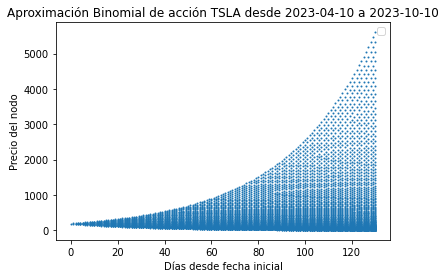

In [6]:
# Gráfiquemos en un scatter plot
x = [p[0] for p in points]
y = [p[1] for p in points]


fig, ax = plt.subplots()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.scatter(x,y, s=1)
ax.set_title('Aproximación Binomial de acción TSLA desde 2023-04-10 a 2023-10-10')
ax.set_ylabel('Precio del nodo')
ax.set_xlabel('Días desde fecha inicial')
plt.show()

c) Recordando lo visto en clases, si ahora queremos calcular el valor de una opción call, el valor $V$ de una opción en $t$ vendría dado por

$$ V= \frac{1}{1+r\delta t}(pV^+ + (1-p)V^-),$$

donde los valores $V^+$ y $V^-$ corresponden a el posible valor mayor y menor de la acción al día siguiante, que calculamos en el item anterior. $p$ corresponde a la probabilidad ficcticia de un mundo sin riesgo, tal que 

$$p=\frac{1}{2}+\frac{r\sqrt{\delta t}}{2\sigma}.$$

Como en este caso queremos modelar una opción call, diremos que su valor será igual a 

$$ V(S,T)=\textit{max}(S-E,0),$$

donde el precio de ejercicio será $E=0,9S_0$ y la tasa de interes $r=0.1$ vienen dados por el enunciado, y $S$ será el valor de la acción en el día del ejercicio. Partiendo desde los ultimos nodos, podemos llegar al valor actual. 